## Modelling Independent Cascade Model in a Undirected Scale Free Network 

A scale free network has a few nodes that are highly connected to other nodes in the network. The presence of such nodes with a much higher degree than most other nodes will give the degree distribution a long tail. A scale-free network is one with a power-law degree distribution. For an undirected network.

$$P_{deg}(k) \propto k^{-\gamma}$$

One can recognize that a degree distribution has a power-law form by plotting it on a log-log scale. As shown in the above scatter plot, the points will tend to fall along a line.

For this investigation, we choose to use the Barabasi-Albert model. The preferential attachment algorithm is suh=ch that the probability that a new node connects to an existing node $i$ is 

$$\pi(k_{i}) = \frac{k_{i}}{\sum_{j} k_{j}}$$

For the BA model, the specific growth and attachment rule leads to $\gamma \approx 3$.

The $\gamma$ value can be affected by factors like :
<ol>
<li> Preferential attachment mechanism </li>
<li> Growth and attachment rules </li>
<li> Initial degree of nodes (m) </li>
<li> Network size (secondary effect) </li>

</ol>

Several natural and human-made systems, including the internet, the world wide web, citation networks, and some social networks are thought to be approximately scale-free. 

Information cascade is a phenomenon in which a number of people make the same decision in a sequantial information. We can generally accept this as a two-step process. First, an individual encounters a scenario with a decision (binary). Second, the decision is influenced by the individual observing others' choice and the apprarent outcomes. There are several information cascade models.

We choose to investigate the Independence Cascade Model(ICM) of Information Diffusion. Node can have three states :
- Inactive - node unaware of information orYb not influenced
- Active - Node already influenced by information in diffusion
- Actived - nodes activated other nodes at prev round, but can not activate other nodes anymore.

The process runs in discrete steps. At the beginning of ICM process, few nodes are given the information known as seed nodes. Upon receiving the information these nodes become active. In each discrete step, an active node tries to influence one of its inactive neighbors. In spite of its success, the same node will never get another chance to activate the same inactive neighbor. The success depends on the propagation probability of their tie. Propagation Probability of a tie is the probability by which one can influence the other node. 

The process terminates when no further nodes became activated from inactive state.

We set the propagation probability to be 

$$p_{ij} = \frac{q}{k_j}$$

Where $j$ is the target node and $i$ is the active node. $q$ is the threshold, a hyper parameter.

# The goal - Influence Maximization

Similar to marketing or broadcasting in the real world. We can choose better seeds that result in a higher number of ultimate active nodes.

Here are some selection policies we will consider:

i. Random
ii. Degree
iii. Fixed degree 
iv. Friend degree
v. Fixed friend degree 

Fixed degree : Using degree ranking has a problem. If we pick a node with high degree but a fraction of its neighbours are actived, these nodes will no longer be considered any more. So the effective degree of the node is actually lower. To fix this, update nodes' (effective) degree after each selection, i.e. after selecting one node as a seed, update the degree its neighbours with -1 to make sure those nodes don't consider this seed anymore.

This helps avoid local seeds gathering.

Neighbour degree : Select seed by nodes' centrality score. 
$$ C_{i} = k_{i} + \sum_{j}k_{j}A_{ij}$$

# The question : Is it worth it ?
The reason we investigate the above is because for a particular network and $q$, does the seeding protocol matter? Transitioning from random to non-random requires knowing the network topology, and adding fixed detail to the seeding protocol requires extra computing work as well. All these extra work can only be justified if there's siginificant improvement in final influenced size.

We focus on a quantity known as E, the effective influence:

$$ E = \frac{<D>}{p_{seed}*n} -1 $$

Where $<D>$ is the mean influenced nodes at termination, the -1 accounts for the seed itself. Think of this quantity as for each seed that I sowed, how many other nodes was it able to influence.
_________________________________________________________________
Bonus : Homophily - popular nodes befriending each other. 

[Scale-free network] https://mathinsight.org/scale_free_network

[Building scale-free/Barabasi-Albert Network] https://github.com/AlxndrMlk/Barabasi-Albert_Network

[How to Code Independent Cascade Model of Information Diffusion] http://home.iitj.ac.in/~suman/articles/detail/how-to-code-independent-cascade-model-of-information-diffusion/#:~:text=Independent%20Cascade%20Model%20(ICM)%20is,by%20the%20information%20in%20diffusion.

[Python implementation of ICM & Selection Policies] https://github.com/cbhua/independent-cascade?tab=readme-ov-file

In [94]:
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
import networkx as nx

# 0 : Implementing Scale-free Network & ICM Simulation

Keep these constant :

- Number of nodes n = 10,000. 
- m = 3.
- Set initial seeds be $p_{seed}=0.01$


In [95]:
class Network():
    def __init__(self,num_nodes):
        self.adj = {i:set() for i in range(num_nodes)}
        self.num_edge = 0
        self.num_nodes=num_nodes

    def add_edge(self,i,j):
        self.adj[i].add(j)
        self.adj[j].add(i)
        self.num_edge+=1

    def neighbors (self,i):
        return self.adj[i]
    
    def edge_list(self):
        return [(i,j) for i in self.adj for j in self.adj[i] if i<j]\
        
    def degree_distribution(self) -> list:
        '''Returns degree of each node'''
        return [len(self.adj[i]) for i in range(self.num_nodes)]



In [96]:
class Barabasi_Albert_Network(Network):
    """Returns a random graph according to the Barabási–Albert preferential
    Attachment model.
 
    A graph of ``n`` nodes is grown by attaching new nodes each with ``m``
    Edges that are preferentially attached to existing nodes with high degree.
 
    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : int, optional
        Seed for random number generator (default=None).
 
    Returns
    -------
    G : Graph
 
    Raises
    ------
    ValueError
        If ``m`` does not satisfy ``1 <= m < n``. """

    def __init__(self, num_nodes, m):
        super().__init__(num_nodes)
        self.num_nodes = num_nodes
        self.m = m

        if m<1 or m>=num_nodes:
            raise ValueError('Barabasi-Albert network must have 1<=m<n')
        
        # Target nodes for new edges
        targets= list(range(m))
        # List of existing nodes, with nodes repeated one for each half edge
        repeated_nodes=[]
        # Start adding the other n-m nodes. The first node is m.
        for node in range(self.num_nodes-m):
            for i,j in zip([node]*m,targets):
                self.add_edge(i,j)
            repeated_nodes.extend(targets)
            repeated_nodes.extend([node]*m)
            # Choose m unique nodes from the existing nodes
            # Pick uniformly from repeated_nodes (preferential attachment)
            targets = np.random.choice(repeated_nodes,m,replace=False)

In [105]:
class ICM_Model():
    """ I: Inactive, A:Active, D:Actived"""
    def __init__(self, network : nx.Graph, q, initial_seeds = None , p_seed=0.05) -> None:
        self.network = network 
        self.q = q
        self.p_seed = p_seed

        # I,A,D states
        self.I = {n for n in self.network}
        self.A = set()
        self.D = set()

        # Initially activate a small fraction of the population 
        if not initial_seeds:
            initial_seeds = np.random.choice(list(self.I), size=int(self.p_seed*self.network.number_of_nodes()), replace=False)

        self.A.update(initial_seeds)
        self.I.difference_update(self.A)

    def run(self):
        '''Runs simulation for a cycle'''

        next_A = set()
        for node in self.A:
            for j in self.network.neighbors(node):
                if j in self.I and np.random.rand() < (self.q/self.network.degree(j)): # type: ignore
                    next_A.add(j)

        self.D.update(self.A)
        self.A = next_A
        self.I.difference_update(next_A)

    def run_to_extinction(self) -> tuple[list[int],list[int],list[int]]:
        '''Run simulation until no more active node is left, then returns time series of IAD numbers as arrays.'''

        I_list, A_list, D_list = [len(self.I)],[len(self.A)],[len(self.D)]

        while self.A:
            self.run()

            I_list.append(len(self.I))
            A_list.append(len(self.A))
            D_list.append(len(self.D))

        return I_list, A_list, D_list

In [98]:
# n = 10000
# m = 3
# network = Barabasi_Albert_Network(n,m)

# degrees = np.bincount(sorted(network.degree_distribution()))
# deg = np.arange(len(degrees))

# plt.scatter(deg,degrees)
# plt.yscale('log')
# plt.xscale('log')
# plt.show()

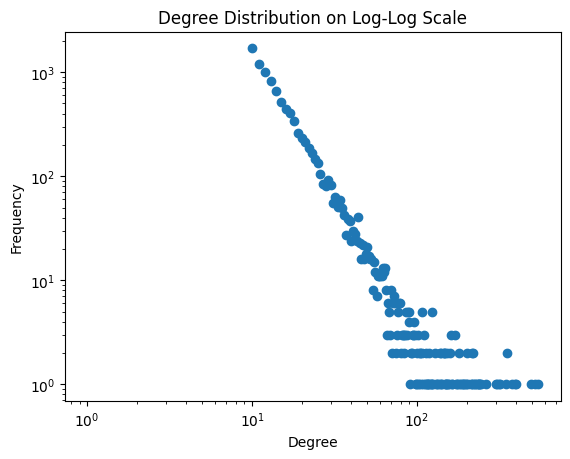

In [99]:
n = 10000
m = 10
G = nx.barabasi_albert_graph(n,m)

# Plot degree distribution on a log-log scale
degree_sequence = [d for n, d in G.degree()]
degree_count = np.bincount(degree_sequence)
deg = np.arange(len(degree_count))

plt.scatter(deg,degree_count)
plt.yscale('log')
plt.xscale('log')
plt.title("Degree Distribution on Log-Log Scale")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()


We will use networkx instead because the graph generation is much faster.

# 1 : States in ICM over time.

Inactive - I
Active - A
Actived - D

Simulate the ICM process. Run the process until extinction - we only have inactive and actived nodes. For a few $q$ values. Plot time series for I,A,D.

Randomly pick the seeds. 

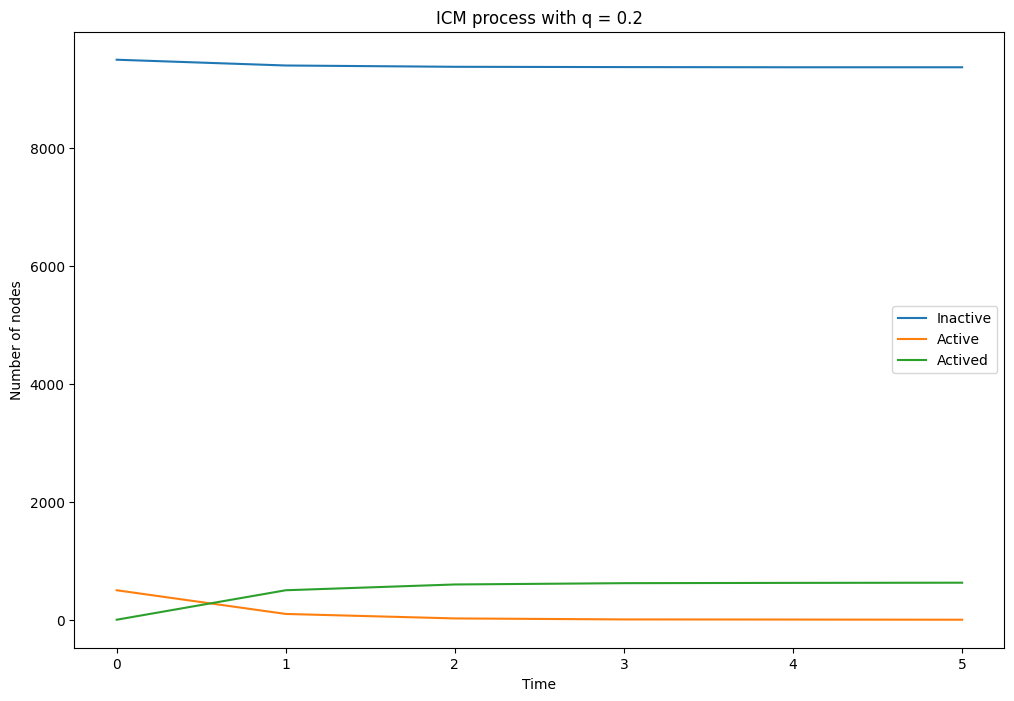

Effective influence = 0.256


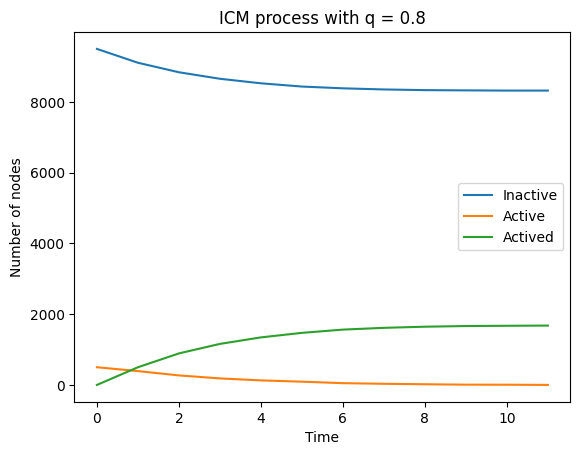

Effective influence = 2.356


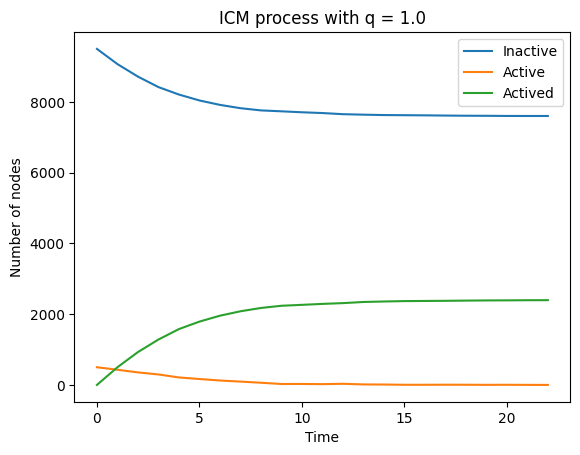

Effective influence = 3.792


In [100]:
q_array = [0.2,0.8,1.0]
p_seed = 0.05

plt.figure(figsize=(12,8))
for q in q_array:
    simulation = ICM_Model(G,q,p_seed)
    I,A,D = simulation.run_to_extinction()

    plt.plot(I, label='Inactive')
    plt.plot(A, label='Active')
    plt.plot(D, label='Actived')
    plt.xlabel('Time')
    plt.ylabel('Number of nodes')
    plt.title('ICM process with q = {}'.format(q))
    plt.legend()
    plt.show()


    # Ratio of influenced size/seeds
    print('Effective influence = {}'.format((D[-1]/(n*p_seed))-1))

# 2 : Investigate influenced size versus propagation probability threshold by random seeding

For a range of $q$ values. Investigate the final size of influenced node, D , in the population, ideally averaged over a few network.

Are there any correlation ? Is there a 'threshold' for $q$ where the dynamic of information cascading changes ? 

In [112]:
def average_D_vs_q(G, q_array, initial_seeds=None, p_seed=0.05, runs=30):
    avg_D = []

    for q in q_array:
        D_values = []
        for _ in range(runs):
            simulation = ICM_Model(G,q,initial_seeds,p_seed)
            I,A,D = simulation.run_to_extinction()
            D_values.append(D[-1])
        avg_D.append(np.mean(D_values))

    return avg_D

In [114]:
q_array = np.linspace(0.0,1.0,10)
avg_D = average_D_vs_q(G, q_array)

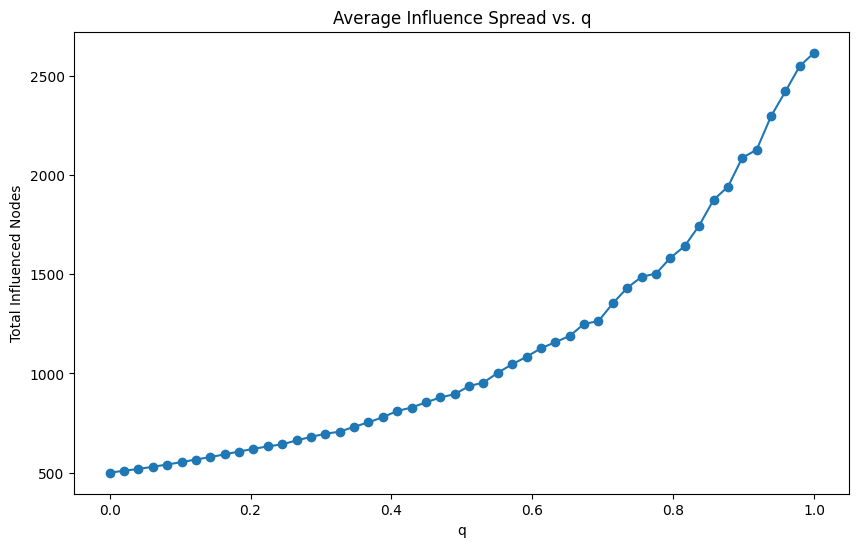

In [102]:
plt.figure(figsize=(10,6))
plt.plot(q_array,avg_D, marker='o')
plt.xlabel('q')
plt.ylabel('Total Influenced Nodes')
plt.title('Average Influence Spread vs. q')
plt.show()

No change in influence spread dynamic as a function of q.

# 3 : Probability that a node is never influenced

The suitable $q$ value for this section will come from Q2.

Find a way to find analytical expression of probability a node is never influenced, $s_{i}$. Compute the vector for it. Then find the mean.

Use the above to estimate 'effectiveness' - ratio of final influence proportion to seed proportion.Final influence proportion is probably $1 - <s>$.

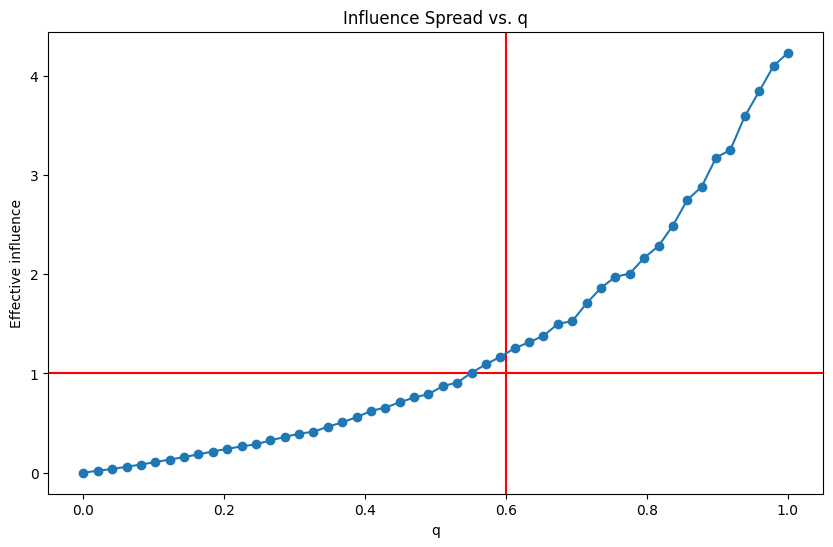

In [103]:
# TODO : Derive analytical expression then plot against graphs in 2

# Simulated influence effectiveness vs. 
plt.figure(figsize=(10,6))
plt.axvline(0.6,color='r')
plt.axhline(1.0,color='r')
plt.plot(q_array,np.array(avg_D)/(p_seed*n)-1, marker='o',label='Simulation')
plt.xlabel('q')
plt.ylabel('Effective influence')
plt.title('Influence Spread vs. q')
plt.show()

The value of q at which effective influence is 1 seems to have positive correlation with mean degree. Maybe I should plot a function of that, and use it to justify why friend degree seeding protocol works.

# 4 : Explore degree seeding protocol

Now, instead of randomly picking seeds. Compute the degree vector and pick those with highest degrees. Repeat above analysis of influenced size as a function of $q$.

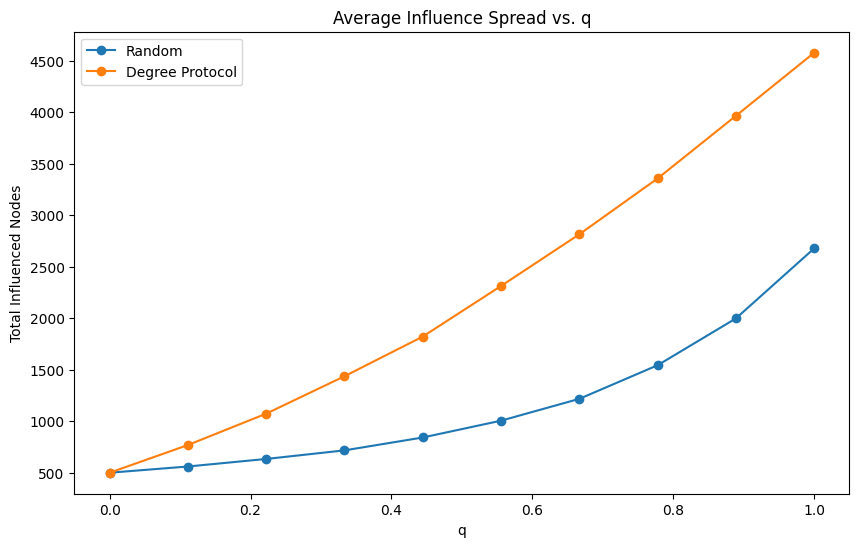

In [115]:
nodes_degree_sorted = sorted(G.degree(), key=lambda x:x[1], reverse=True)
highest_degree_nodes = [n for n,d in nodes_degree_sorted[:int(n*p_seed)]]

q_array = np.linspace(0.0,1.0,10)
avg_D_II = average_D_vs_q(G, q_array, highest_degree_nodes)

plt.figure(figsize=(10,6))
plt.plot(q_array,avg_D, marker='o', label='Random')
plt.plot(q_array,avg_D_II, marker='o', label='Degree Protocol')
plt.legend()
plt.xlabel('q')
plt.ylabel('Total Influenced Nodes')
plt.title('Average Influence Spread vs. q')
plt.show()


# 5 : Explore friend degree seeding protocol

Compute centrality score $c_{i}$ of a node by adding up their own degree and their neighbours degree. Pick nodes of highest centrality score as seed. Repeat analyis.

# 6 : Explore fixed degree seeding protocol

Start with a seed, then for all the neighbours of the seed, -1 with their degree. Pick node of next highest degree as next seed. Repeat degree adjustmenet and picking until $p_{seed}*n$ nodes selected. Repeat analysis.

Compare time complexity for the process so far.

# 7 : Explore fixed friend degree seeding protocol

Self-explanatory. If fixed seeding protocol takes too long just ditch and do degree vs friend degree investigation.